# Calculate Perplexity for Russian dataset

In [1]:
import math
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np

In [2]:
def parse_dataset(filename):
    sentences = []
    tokens = []
    labels = []
    id = ''
    with open(filename, 'r', encoding='utf8') as f:
        for line in f:
            # if line refers to id
            line_t = line.replace('\n', '')
            if len(line_t) == 0:
                if len(tokens) > 0:
                    sentences.append((id, tokens, labels))
            # if line is empty
            elif line_t[0] == '#':
                id = line_t[5:line_t.find('domain') - 1]
                tokens = []
                labels = []
            # if line refers to token and label
            else:
                token = line_t[:line_t.find('_') - 1]
                label = line_t[line_t.rfind('_') + 2:]
                tokens.append(token)
                labels.append(label)
    return sentences

In [3]:
sentences = parse_dataset('data/RU-Russian/ru_train.conll')

In [4]:
total = 0
cnt = Counter()

for _, sent, tags in sentences:
    tokens = [x.lower() for x in word_tokenize(' '.join(sent))]
    for t in tokens:
        total += 1
        cnt[t] += 1

In [5]:
def calculate_perplexity(sent, counter, total):
    res = 0
    tokens = [x.lower() for x in word_tokenize(' '.join(sent))]
    for k in tokens:
        if k in counter:
            if counter[k] != 0:
                res += math.log(counter[k] / total, 2)
    return 2 ** (-1 * (res / total))

In [6]:
perplexities = []
for _, sent, tags in sentences:
    l = calculate_perplexity(sent, cnt, total)
    perplexities.append(l)

In [7]:
np.mean(perplexities)

1.0005198640820314

In [8]:
np.std(perplexities)

0.00019489720826440225

In [12]:
import matplotlib.pyplot as plt

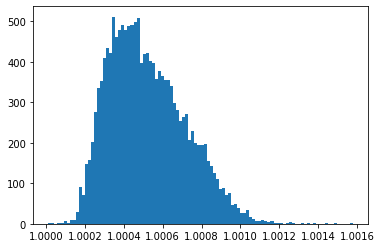

In [13]:
plt.hist(perplexities, bins=100)
plt.show()

In [22]:
min(perplexities)

1.0000115420124616

In [24]:
max(perplexities)

1.0015770400945676

# Translate English to Russian

In [9]:
from easynmt import EasyNMT
import sys
import os
import time

In [10]:
translator = EasyNMT('mbart50_en2m')
sl = 'en'
tl = 'ru'

In [30]:
def postprocess(t, dict1):
    t = t.replace("-"," ")
    t = t.replace("&quot;","\"")
    t = t.replace("&#39;","'")
    t = t.replace(" DOCSTART ","-DOCSTART-")
    for a, b in dict1.items():
        t = t.replace(a, b)
    t = t.replace("​","")
    return t


def preprocess(sentence):
    original = ''
    tmp = []
    string = []
    dict1 = {}
    n = 0
    s=""
    v=""
    for w in sentence:
        original = ' '.join([w[0] for w in sentence])
    if original == '':
        return None, dict1
    for i in range(len(sentence)):
        w = sentence[i]
        if w[1][:1]=="B":
            string.append(w[0])
        elif w[1][:1]=="I":
            string.append(w[0])
        elif w[1][:1]=="O":
            tmp.append(w[0])
            if len(string) > 0:
                s = ' '.join([w for w in string])
                string = []
        if i == len(sentence) - 1:
            if len(string) > 0:
                s = ' '.join([w for w in string])
                string = []
        if s !="":
            ner = w[1][2:]
            if ner in ["PER", "LOC", "CORP", "PROD", "CW"]:
                s1 = "["+s+"]"
                new = original.replace(s,s1)
                results2 = translator.translate(new, source_lang=sl, target_lang=tl)
                t2 = results2
                t2 = t2.replace("&quot;","\"")
                t2 = t2.replace("&#39;","'")
                t2 = t2.replace("&amp;","&")
                if tl == 'nl':
                    pass
                else:
                    t2 = t2.replace('-',' ')
                t2 = word_tokenize(t2)
                t2 = ' '.join([w for w in t2])
                w1 = t2.split()
                l = len(w1)
                t3 = ""
                for i in range(l):
                    if w1[i][:1] =="[" and w1[i][-1:] =="]":
                        t3 = w1[i]
                        break
                    elif w1[i][:1] =="[" and w1[i][-1:] !="]":
                        t3 = w1[i]
                    elif w1[i][:1] !="[" and w1[i][-1:] =="]":
                        t3 = t3+" "+w1[i]
                        break
                    else:
                        t3 = t3+" "+w1[i]
                if "[" not in t3:
                    if ner == "LOC":
                        s1 = "[Location] "+s
                    elif ner == "PER":
                        s1 = "[Name] "+s
                    elif ner == "CW":
                        s1 = "[Creative work] "+s
                    elif ner == "CORP":
                        s1 = "[Corporarion] "+s
                    elif ner == "PROD":
                        s1 = "[Product] "+s
                    elif ner == "GRP":
                        s1 = "[Group] "+s
                    results2 = translator.translate(s1, source_lang=sl, target_lang=tl)
                    t2 = results2
                    t2 = t2.replace("&quot;","\"")
                    t2 = t2.replace("&#39;","'")
                    t2 = t2.replace("&amp;","&")
                    if tl == 'nl':
                        pass
                    else:
                        t2 = t2.replace('-',' ')
                    w2 = t2.split()
                    l = len(w2)
                    t3 = ""
                    for i in range(l):
                        if w2[i][:1] !="[":
                            if i == 0:
                                t3 = w2[i]
                            else:
                                t3 = t3 +" "+w2[i]
                t3 = t3.replace("[","")
                t3 = t3.replace("]","")
                if n > 9:
                    g2 =ner+"t"+str(n)
                else:
                    g2 =ner+str(n)
                n=n+1
                tmp.append(g2)
                keys = []
                keys.append(g2)
                w2 = t3.split()
                l = len(w2)
                if l == 1:
                    v = "B-"+ner+" "+w2[0]
                elif l > 1:
                    for i in range(l):
                        if i == 0:
                            v = "B-"+ner+" "+w2[i]
                        else:
                            v = v+" "+"I-"+ner+" "+w2[i]
                values = []
                values.append(v)
                d1 = dict(zip(keys,values))
                if dict1 == {}:
                    dict1.update(d1)
                elif g2 not in dict1:
                    dict1.update(d1)
                s=""
                string=[]
                ner=""
                t3=""

    return ' '.join([w for w in tmp]), dict1

In [31]:
def run(fpath, ofpath):
    sentence = []
    print("Start the process.")
    with open(fpath, 'r', encoding='utf8') as inf, open(ofpath, 'w+', encoding='utf8') as of:
        count = 0
        deleted = 0
        sentence_id = ''
        for line in inf:
            # if line refers to id
            line_t = line.replace('\n', '')
            if len(line_t) == 0:
                sentence_preprocessed, dict1 = preprocess(sentence)
                if sentence_preprocessed is None:
                    continue
#                 print(f'original:\t{sentence_preprocessed}')
                results = translator.translate(sentence_preprocessed, source_lang=sl, target_lang=tl)
                t = postprocess(results, dict1)
                perplex = calculate_perplexity(t, cnt, total)
                if perplex >= 1 and perplex <= 1.0016:
#                 print(f'translated\t{t}')
                    t_splitted = [x for x in t.split() if len(x) > 0]
                    i = 0
                    of.write(sentence_id + '\n')
                    while i < len(t_splitted):
                        if t_splitted[i][:2] == 'B-' or t_splitted[i][:2] == 'I-':
                            of.write(t_splitted[i + 1] + ' _ _ ' + t_splitted[i] + '\n')
                            i += 2
                        else:
                            of.write(t_splitted[i] + ' _ _ O' + '\n')
                            i += 1
                    of.write('\n')
                else:
                    deleted += 1
                sentence = []
                count += 1
                if count % 1000 == 0:
                    print('-----------------------')
                    print(f'{count} sentences done')
                    print('-----------------------')
            # if line is empty
            elif line_t[0] == '#':
                sentence_id = line_t[5:line_t.find('domain') - 1]
                sentence = []
            # if line refers to token and label
            else:
                token = line_t[:line_t.find('_') - 1]
                label = line_t[line_t.rfind('_') + 2:]
                sentence.append([token, label])
        print(f'{deleted} sentences not included')

In [32]:
fpath ='data/EN-English/en_train.conll'
ofpath = 'data/RU-Russian/ru_train_new.conll'
run(fpath, ofpath)

Start the process.


KeyboardInterrupt: 